In [4]:
import sys
sys.path.append('../Automatic-Circuit-Discovery/')
sys.path.append('..')
import os
import re
import json
import pandas as pd
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-v0_8-paper')


device = t.device("cuda" if t.cuda.is_available() else "CPU")
print(device)

cuda


# Get experiment to find edges

In [ ]:
from acdc.docstring.utils import get_all_docstring_things
from acdc.TLACDCExperiment import TLACDCExperiment
all_docstring_items = get_all_docstring_things(num_examples=40, seq_len=5, device=device, metric_name='docstring_metric', correct_incorrect_wandb=False)

model = all_docstring_items.tl_model
test_metrics = all_docstring_items.test_metrics['docstring_metric']
test_data = all_docstring_items.test_data
test_patch_data = all_docstring_items.test_patch_data

exp = TLACDCExperiment(
            model=model,
            threshold=0,
            ds=test_data,
            ref_ds=test_patch_data,
            metric=test_metrics,
            run_name=None,
        )
exp.model.reset_hooks()
exp.setup_model_hooks(
    add_sender_hooks=True,
    add_receiver_hooks=True,
    doing_acdc_runs=False
)

del all_docstring_items

# Clean collected data, gather heads and edges

In [25]:
def clean_pruned_heads(pruned_heads):
    cleaned_heads = {}

    for thresh in pruned_heads.keys():
        cleaned_heads[thresh] = {}
        cleaned_heads[thresh]['acdcpp'] = set()
        cleaned_heads[thresh]['acdc'] = set()

        for i in range(2):
            for head in pruned_heads[thresh][i]:
                attn_head_pttn = re.compile('^<a([0-9]+)\.([0-9]+)>$')
                matched = attn_head_pttn.match(head)
                if matched:
                    head_str = f'{matched.group(1)}.{matched.group(2)}'
                    if i == 0:
                        cleaned_heads[thresh]['acdcpp'].add(head_str)
                    else:
                        cleaned_heads[thresh]['acdc'].add(head_str)
    return cleaned_heads

def get_all_heads(num_layers, num_heads):
    all_heads = set()

    for layer in range(num_layers):
        for head in range(num_heads):
            all_heads.add(f'{layer}.{head}')
    return all_heads

def convert_to_torch_index(index_list):
    return ''.join(['None' if i == ':' else i for i in index_list])

def get_all_edges(exp):
    all_edges = set()
    for child_name in exp.corr.edges:
        for child_idx in exp.corr.edges[child_name]:
            child_idx_converted = convert_to_torch_index(str(child_idx))
            for parent_name in exp.corr.edges[child_name][child_idx]:
                for parent_idx in exp.corr.edges[child_name][child_idx][parent_name]:
                    parent_idx_converted = convert_to_torch_index(str(parent_idx))
                    all_edges.add(f'{parent_name}{parent_idx_converted}{child_name}{child_idx_converted}')
    return all_edges

In [59]:
from acdc.docstring.utils import get_docstring_subgraph_true_edges

with open('abs_edges_pruned_heads_docstring.json', 'r') as f:
    pruned_heads = json.load(f)
with open('abs_edges_pruned_attrs_docstring.json', 'r') as f:
    pruned_attrs = json.load(f)
with open('abs_edges_num_passes_docstring.json', 'r') as f:
    num_passes = json.load(f)
    
# NODES
docstring_heads = set(['0.1', '0.2', '0.4', '0.5', '1.2', '1.4', '2.0', '2.3', '3.0', '3.6'])
print(len(docstring_heads))

pruned_heads = clean_pruned_heads(pruned_heads)

# 4 layers, 8 head model
all_heads = get_all_heads(4, 8)

# EDGES
all_edges = get_all_edges(exp)

pruned_edges = set()
for thresh in pruned_attrs.keys():
    for (parent_name, parent_idx, child_name, child_idx, attr) in pruned_attrs[thresh]:
        pruned_edges.add(f'{parent_name}{parent_idx}{child_name}{child_idx}')
        
true_edges_tuples = get_docstring_subgraph_true_edges()
true_edges = set()
replace_parens = lambda tup: str(tup).replace('(', '[').replace(')', ']').replace('[None,]', '[None]')

for child_name, child_idx, parent_name, parent_idx in true_edges_tuples:
    true_edges.add(f'{parent_name}{replace_parens(parent_idx)}{child_name}{replace_parens(child_idx)}')

10


In [60]:
for edge in all_edges:
    if 'blocks.0.hook_resid_pre' in edge:
        print(edge)

blocks.0.hook_resid_pre[None]blocks.0.hook_k_input[None, None, 3]
blocks.0.hook_resid_pre[None]blocks.3.hook_v_input[None, None, 5]
blocks.0.hook_resid_pre[None]blocks.2.hook_k_input[None, None, 6]
blocks.0.hook_resid_pre[None]blocks.0.hook_v_input[None, None, 7]
blocks.0.hook_resid_pre[None]blocks.3.hook_q_input[None, None, 5]
blocks.0.hook_resid_pre[None]blocks.3.hook_v_input[None, None, 6]
blocks.0.hook_resid_pre[None]blocks.1.hook_v_input[None, None, 7]
blocks.0.hook_resid_pre[None]blocks.1.hook_k_input[None, None, 2]
blocks.0.hook_resid_pre[None]blocks.0.hook_q_input[None, None, 4]
blocks.0.hook_resid_pre[None]blocks.3.hook_k_input[None, None, 7]
blocks.0.hook_resid_pre[None]blocks.1.hook_q_input[None, None, 7]
blocks.0.hook_resid_pre[None]blocks.1.hook_q_input[None, None, 6]
blocks.0.hook_resid_pre[None]blocks.1.hook_q_input[None, None, 5]
blocks.0.hook_resid_pre[None]blocks.1.hook_v_input[None, None, 2]
blocks.0.hook_resid_pre[None]blocks.1.hook_k_input[None, None, 5]
blocks.0.h

# Validate edge data

In [62]:
# pruned_edges, true_edges should all be in all_edges
for pruned_edge in pruned_edges:
    if not pruned_edge in all_edges:
        print(pruned_edge)
print('Pruned edge test complete')
for true_edge in true_edges:
    if not true_edge in all_edges:
        print(true_edge)
print('True edge test complete')

Pruned edge test complete
True edge test complete


# Calculate Metrics

In [19]:
data = {
    'Threshold': [0],
    'ACDCpp TPR': [1],
    'ACDCpp TNR': [0],
    'ACDCpp FPR': [1],
    'ACDCpp FNR': [0],
    'TPR': [1],
    'TNR': [0],
    'FPR': [1],
    'FNR': [0],
    'Num Passes': [np.inf],
}

for thresh in pruned_edges.keys():
    data['Threshold'].append(round(float(thresh), 3)) # Correct rounding error
    # Variables prefixed with pp_ are after ADCDCpp only
    pp_heads = pruned_edges[thresh]['acdcpp']
    heads = pruned_edges[thresh]['acdc']
    
    pp_tp = len(pp_heads.intersection(docstring_heads))
    pp_tn = len((all_heads - docstring_heads).intersection(all_heads - pp_heads))
    pp_fp = len(pp_heads - docstring_heads)
    pp_fn = len(docstring_heads - pp_heads)

    tp = len(heads.intersection(docstring_heads))
    tn = len((all_heads - docstring_heads).intersection(all_heads - heads))
    fp = len(heads - docstring_heads)
    fn = len(docstring_heads - heads)

    pp_tpr = pp_tp / (pp_tp + pp_fn)
    pp_tnr = pp_tn / (pp_tn + pp_fp)
    pp_fpr = 1 - pp_tnr
    pp_fnr = 1 - pp_tpr

    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = 1 - tnr
    fnr = 1 - tpr

    data['ACDCpp TPR'].append(pp_tpr)
    data['ACDCpp TNR'].append(pp_tnr)
    data['ACDCpp FPR'].append(pp_fpr)
    data['ACDCpp FNR'].append(pp_fnr)

    data['TPR'].append(tpr)
    data['TNR'].append(tnr)
    data['FPR'].append(fpr)
    data['FNR'].append(fnr)

    data['Num Passes'].append(num_passes[thresh])
df = pd.DataFrame(data)
# Add thresh inf to end of df
row = [np.inf, 0, 1, 0, 1, 0, 1, 0, 1, 0]
df.loc[len(df)] = row

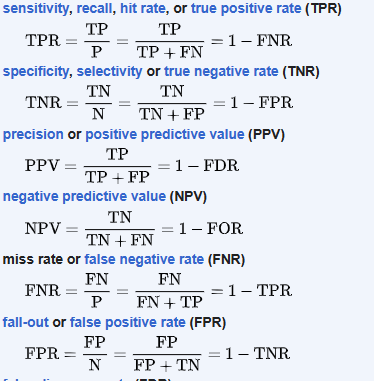

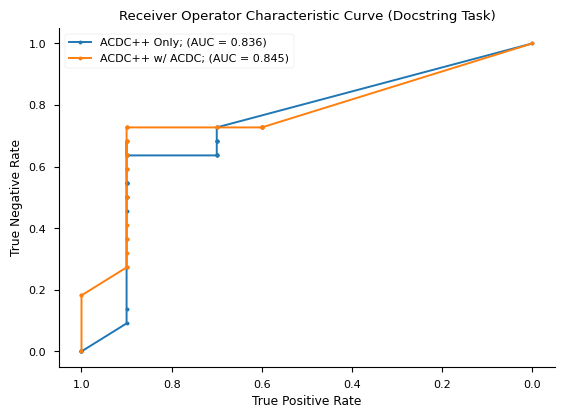

In [20]:
# Calculate AUC using trapezoidal rule
auc = round(np.sum(np.array(df['TPR'])[:-1] * np.diff(np.array(df['TNR']))),3)
pp_auc = round(np.sum(np.array(df['ACDCpp TPR'])[:-1] * np.diff(np.array(df['ACDCpp TNR']))),3)

plt.plot(df['ACDCpp TPR'], df['ACDCpp TNR'], marker='.', label=f'ACDC++ Only; (AUC = {pp_auc})')
plt.plot(df['TPR'], df['TNR'], marker='.', label=f'ACDC++ w/ ACDC; (AUC = {auc})')
plt.xlabel('True Positive Rate')
plt.ylabel('True Negative Rate')
plt.title('Receiver Operator Characteristic Curve (Docstring Task)')
plt.legend()
plt.gca().invert_xaxis()

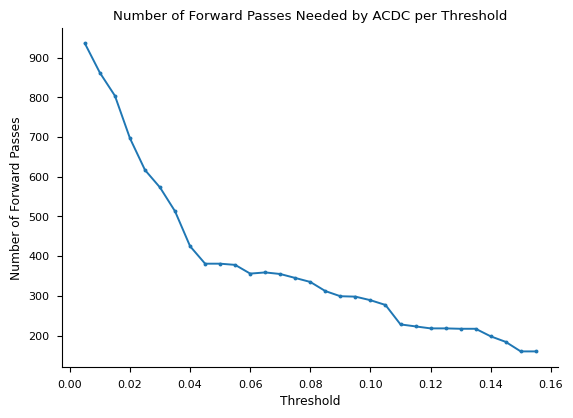

In [21]:
plt.plot(df['Threshold'], df['Num Passes'], marker='.')
plt.xlabel('Threshold')
plt.ylabel('Number of Forward Passes')
plt.title('Number of Forward Passes Needed by ACDC per Threshold')
plt.show()